<a href="https://colab.research.google.com/github/mahirapuri/Machine-Learning/blob/main/Superhero_Name_Generator_Learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Superhero (and Supervillain) Name Generator

---

[Superhero Names Dataset](https://github.com/am1tyadav/superhero)

TASK 2

1. Import the data
2. Create a tokenizer
3. Char to index and Index to char dictionaries

In [ ]:
!git clone https://github.com/am1tyadav/superhero

Cloning into 'superhero'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [ ]:
with open('superhero/superheroes.txt', 'r') as f:
  data = f.read()

  data[:100]

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

## Task 3

1. Converting between names and sequences

In [ ]:
tokenizer.fit_on_texts(data) # convert seq of char to numbers 

In [ ]:
char_to_index = tokenizer.word_index
index_to_char = dict((v,k) for k, v in char_to_index.items()) #does tokenizer assign random values?
print(index_to_char)

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


In [ ]:
#names to seq and seq to names 

In [ ]:
names = data.splitlines() #splitting data into newline chars
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [ ]:
tokenizer.texts_to_sequences(names[0]) #converting the first example to seq of numbers, we using tokenzier, use text to seq fn and pass our string

[[25], [16], [12], [20], [2], [1]]

In [ ]:
def name_to_seq(name):
 return [tokenizer.texts_to_sequences(c)[0][0] for c in name] #fn converting names to seq

In [ ]:
name_to_seq(names[0])


[25, 16, 12, 20, 2, 1]

In [ ]:
def seq_to_name(seq):
  return ''.join([index_to_char[i] for i in seq if i !=0]) #tokenzier starts from 1 and not 0 bec zero not defined
  #we wanna join the char representation of the numbers so we iterate over the sequence 25 etc and look at the char value associated with that index and then join those to create a name.

In [ ]:
seq_to_name(name_to_seq(names[0])) 

'jumpa\t'

## Task 4

1. Creating sequences
2. Padding all sequences

In [ ]:
sequences= []

for name in names:
   seq = name_to_seq(name)
   if len(seq)>=2 :
     sequences += [seq[:i] for i in range(2, len(seq)+1)]

In [ ]:
sequences[:10] #chopping the names in min len 2 and max len whatever 

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [ ]:
#need to know max len cuz we should have fixed len; padding w zeroes
max_len = max([len(x) for x in sequences])
print(max_len)

33


In [ ]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, padding='pre', #pre padding because it makes it easier to create labels bec the last char is always gonn be label
    maxlen=max_len
   )
print(padded_sequences[0]) 

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [ ]:
padded_sequences.shape

(88279, 33)

## Task 5: Creating Training and Validation Sets

1. Creating training and validation sets

In [ ]:
x, y = padded_sequences[:,:-1], padded_sequences[:,-1]
print(x.shape,y.shape)
#len of seq for our examples is 32.


(88279, 32) (88279,)


In [ ]:
#tts
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
#we have 60k train examples and 20k test examples


(66209, 32) (66209,)
(22070, 32) (22070,)


In [ ]:
num_chars = len(char_to_index.keys()) +1 #+1 bec we have also included zero
print(num_chars) #a to z, space, tab,0

29


## Task 6: Creating the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM
from tensorflow.keras.layers import Bidirectional, Dense 

model = Sequential([
                    Embedding(num_chars, 8, input_length=max_len-1),
                    Conv1D(64,5,strides=1,activation='tanh',padding='causal'),
                    MaxPool1D(2),
                    LSTM(32),
                    Dense(num_chars,activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 8)             232       
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            2624      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 29)                957       
Total params: 16,229
Trainable params: 16,229
Non-trainable params: 0
_________________________________________________________________


## Task 7: Training the Model

In [ ]:
h = model.fit(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=50, verbose=2,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
    ]
)

Epoch 1/50
2070/2070 - 48s - loss: 2.7427 - accuracy: 0.1894 - val_loss: 2.6102 - val_accuracy: 0.2202
Epoch 2/50
2070/2070 - 16s - loss: 2.5505 - accuracy: 0.2352 - val_loss: 2.5195 - val_accuracy: 0.2415
Epoch 3/50
2070/2070 - 16s - loss: 2.4777 - accuracy: 0.2512 - val_loss: 2.4679 - val_accuracy: 0.2508
Epoch 4/50
2070/2070 - 16s - loss: 2.4264 - accuracy: 0.2672 - val_loss: 2.4258 - val_accuracy: 0.2675
Epoch 5/50
2070/2070 - 16s - loss: 2.3869 - accuracy: 0.2757 - val_loss: 2.3969 - val_accuracy: 0.2734
Epoch 6/50
2070/2070 - 16s - loss: 2.3551 - accuracy: 0.2850 - val_loss: 2.3660 - val_accuracy: 0.2802
Epoch 7/50
2070/2070 - 16s - loss: 2.3275 - accuracy: 0.2920 - val_loss: 2.3470 - val_accuracy: 0.2871
Epoch 8/50
2070/2070 - 16s - loss: 2.3023 - accuracy: 0.3009 - val_loss: 2.3302 - val_accuracy: 0.2930
Epoch 9/50
2070/2070 - 16s - loss: 2.2807 - accuracy: 0.3096 - val_loss: 2.3158 - val_accuracy: 0.2995
Epoch 10/50
2070/2070 - 16s - loss: 2.2612 - accuracy: 0.3167 - val_loss:

## Task 8: Generate Names!

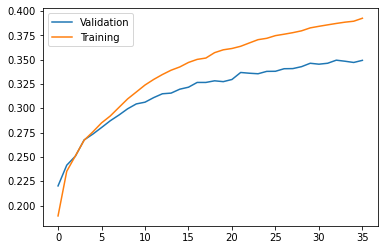

In [ ]:
from matplotlib import pyplot as plt 

epochs_ran = len(h.history['loss'])

plt.plot(range(0,epochs_ran),h.history['val_accuracy'],label='Validation')
plt.plot(range(0,epochs_ran),h.history['accuracy'],label='Training')
plt.legend()
plt.show()



In [ ]:
def generate_names(seed):
  for i in range(0,40):
    seq = name_to_seq(seed)
    padded = tf.keras.preprocessing.sequence.pad_sequences([seq],padding='pre',
                                                                maxlen=max_len-1,
                                                           truncating='pre')
    
    pred=model.predict(padded)[0]
    pred_char = index_to_char[tf.argmax(pred).numpy()]
    seed += pred_char

    if pred_char =='\t':
      break
  print(seed)


In [ ]:
generate_names('a')

artiman	


In [ ]:
generate_names('go')

golden gorde	


In [ ]:
generate_names('woody')

woody man	
